# Satellite-Derived Bathymetry (SDB): Model Development

This notebook implements the machine learning regression algorithm for Satellite-Derived Bathymetry. We utilize the **Extreme Gradient Boosting (XGBoost) Regressor** algorithm to learn the non-linear relationship between satellite spectral features (or embeddings) and water depth.

**Workflow Stages:**
1.  **Data Loading:** Ingesting the preprocessed training and testing arrays (`.npy`).
2.  **Hyperparameter Optimization:** Using `RandomizedSearchCV` to find the optimal model configuration (learning rate, depth, regularization, etc.) to prevent overfitting.
3.  **Model Training:** Training the XGBoost regressor on the full training set using the best parameters.
4.  **Evaluation:** Assessing model performance on unseen test data using standard hydrographic metrics (RMSE, MAE, $R^2$).
5.  **Interpretation:** Analyzing Feature Importance to understand which spectral bands drive the depth predictions.
6.  **Serialization:** Saving the trained model for future inference/mapping.


In [49]:
import os
import time
import joblib
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-whitegrid')


In [ ]:
# ==========================================
# 1. CONFIGURATION
# ==========================================

# --- Input/Output Paths ---
# Directory containing X_train.npy, y_train.npy, etc.
INPUT_DIR = r'train-test dataset'

# Reference raster to extract band names for Feature Importance plot
# (Ensure this path points to one of your downloaded/corrected images)
REFERENCE_RASTER_PATH = r'data\corrected\corrected_s2_giliketapang_2018-05-31.tif'

# Directories to save the Model and Plots
MODEL_OUTPUT_DIR = r'model'
PLOT_OUTPUT_DIR = r'model\plot'

# Create directories if they do not exist
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)

print(f"Model will be saved to: {MODEL_OUTPUT_DIR}")
print(f"Plots will be saved to: {PLOT_OUTPUT_DIR}")

Model will be saved to: model\embeddings
Plots will be saved to: model\embeddings\plot


In [51]:
# ==========================================
# 2. LOAD & VERIFY DATA
# ==========================================

print("Loading datasets...")

try:
    X_train = np.load(os.path.join(INPUT_DIR, 'X_train.npy'))
    X_test = np.load(os.path.join(INPUT_DIR, 'X_test.npy'))
    y_train = np.load(os.path.join(INPUT_DIR, 'y_train.npy'))
    y_test = np.load(os.path.join(INPUT_DIR, 'y_test.npy'))

    print(f"Training Set: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing Set:  X={X_test.shape},  y={y_test.shape}")

    # --- Data Integrity Check ---
    # Ensure no NaNs or Infinites exist (XGBoost can handle them, but cleaning is safer)
    if np.isnan(X_train).any() or np.isnan(y_train).any():
        print("Warning: NaNs detected in training data. Removing invalid rows...")
        valid_mask = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
        X_train = X_train[valid_mask]
        y_train = y_train[valid_mask]
        print(f"New Training Shape: {X_train.shape}")

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please check if the 'INPUT_DIR' path is correct and .npy files exist.")

Loading datasets...
Training Set: X=(738, 64), y=(738,)
Testing Set:  X=(317, 64),  y=(317,)


## 4. Hyperparameter Tuning
We use **Randomized Search** to explore the hyperparameter space. This method is more efficient than Grid Search as it samples a fixed number of parameter settings from specified distributions.

**Key Hyperparameters:**
* `n_estimators`: Number of boosting rounds (trees).
* `learning_rate` (eta): Step size shrinkage to prevent overfitting.
* `max_depth`: Maximum depth of a tree (controls model complexity).
* `subsample` & `colsample_bytree`: Stochastic features (fraction of data/columns used per tree).

In [52]:
# ==========================================
# 3. HYPERPARAMETER TUNING
# ==========================================

print("Initializing Randomized Search...")

# 1. Define Search Space
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.3, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1], # L1 regularization
    'reg_lambda': [1, 1.5, 2, 5]    # L2 regularization
}

# 2. Initialize Base Regressor
# 'hist' tree method is much faster for larger datasets
xgb_model = XGBRegressor(
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

# 3. Configure Cross-Validation Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,                # Number of parameter settings that are sampled
    scoring='neg_root_mean_squared_error', # Optimize for RMSE
    cv=5,                     # 5-Fold Cross Validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 4. Run Tuning
start_time = time.time()
print("Fitting model (this may take a while)...")
random_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# 5. Retrieve Results
best_xgb = random_search.best_estimator_

print("-" * 30)
print(f"Tuning Completed in {elapsed_time:.2f} seconds.")
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best CV Score (RMSE): {-random_search.best_score_:.4f}")

Initializing Randomized Search...
Fitting model (this may take a while)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
------------------------------
Tuning Completed in 17.02 seconds.
Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV Score (RMSE): 0.9890


## 4. Model Evaluation
We evaluate the tuned model on the **independent test set** (30% of data).

**Metrics:**
* **RMSE (Root Mean Squared Error):** Standard deviation of the prediction errors (same unit as depth, meters). Lower is better.
* **MAE (Mean Absolute Error):** Average absolute difference between predicted and actual depth.
* **$R^2$ (Coefficient of Determination):** Proportion of variance in depth explained by the model (1.0 is perfect).


--- Evaluating Model ---
Results for SDB Prediction:
  RMSE: 0.8819 m
  MAE:  0.5889 m
  R2:   0.9782
  Plot saved: model\embeddings\plot\sdb_accuracy_plot_embeddings.png


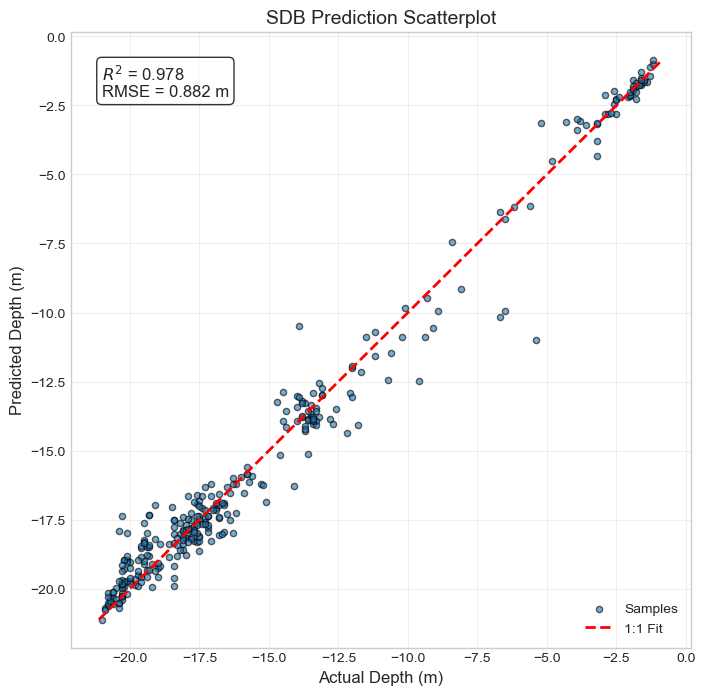

In [53]:
# ==========================================
# 5. EVALUATION
# ==========================================
print("\n--- Evaluating Model ---")

def scatterplot(y_true, y_pred, title, filename):
    """
    Generates a regression scatterplot with metrics embedded in the figure.
    """
    # 1. Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Results for {title}:")
    print(f"  RMSE: {rmse:.4f} m")
    print(f"  MAE:  {mae:.4f} m")
    print(f"  R2:   {r2:.4f}")

    # 2. Create Plot
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', s=20, label='Samples')
    
    # Perfect 1:1 prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1 Fit')
    
    # Labels & Title
    plt.xlabel('Actual Depth (m)', fontsize=12)
    plt.ylabel('Predicted Depth (m)', fontsize=12)
    plt.title(f'{title} Scatterplot', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    # 3. Add metrics text box inside the plot
    stats_text = f"$R^2$ = {r2:.3f}\nRMSE = {rmse:.3f} m"
    plt.gca().text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
                   verticalalignment='top', fontsize=12,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 4. Save Plot
    # Using PLOT_OUTPUT_DIR defined in Configuration cell
    save_path = os.path.join(PLOT_OUTPUT_DIR, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  Plot saved: {save_path}")
    plt.show()

# --- Execution ---
# Predict on Test Set
y_pred = best_xgb.predict(X_test)

# Generate Plot
scatterplot(y_test, y_pred, "SDB Prediction", "sdb_accuracy_plot_embeddings.png")


--- Generating Feature Importance ---
Feature importance plot saved: model\embeddings\plot\feature_importance.png


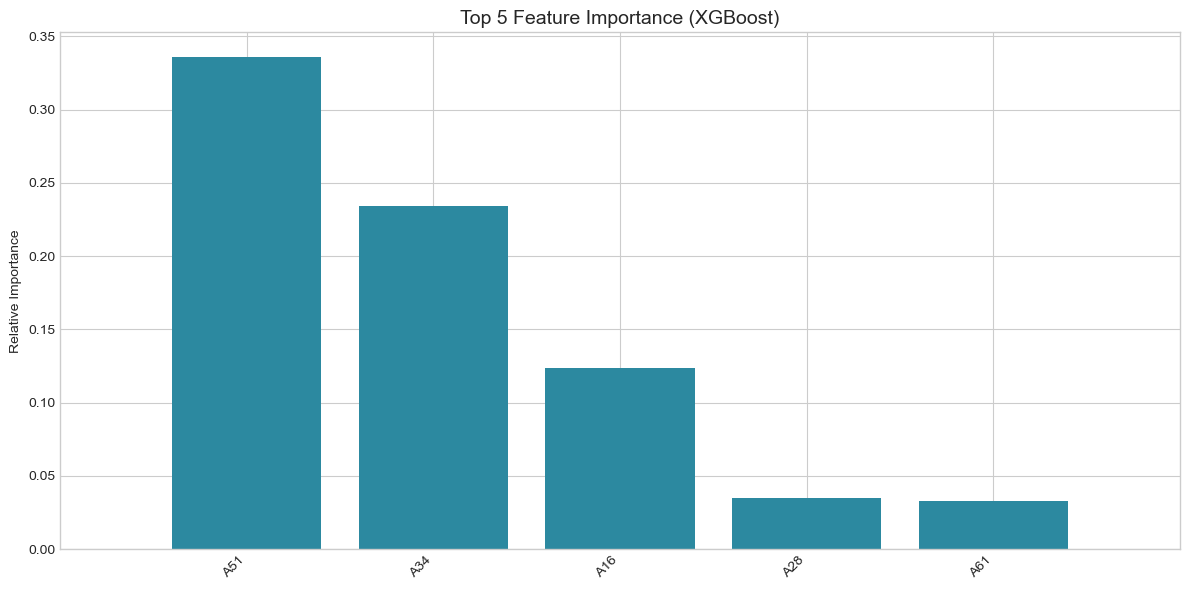

In [54]:
# ==========================================
# 6. FEATURE IMPORTANCE
# ==========================================

print("\n--- Generating Feature Importance ---")

# 1. Retrieve Feature Names
# Attempt to read from the reference raster metadata (if available)
try:
    with rasterio.open(REFERENCE_RASTER_PATH) as src:
        # Check if descriptions exist in the TIF
        if any(src.descriptions):
            feature_names = list(src.descriptions)
        else:
            # Fallback for generic bands (or Embeddings A01-A64)
            feature_names = [f"Band_{i+1}" for i in range(X_train.shape[1])]
            # Optional: If you know it is Embeddings, you can force naming:
            # feature_names = [f"Embed_{i+1}" for i in range(64)]
            
except Exception as e:
    print(f"Notice: Could not read raster metadata ({e}). Using generic names.")
    feature_names = [f"Feature_{i+1}" for i in range(X_train.shape[1])]

# 2. Get Importance from Model
importances = best_xgb.feature_importances_
# Sort indices in descending order
indices = np.argsort(importances)[::-1]

# 3. Plot Top 5 Features
top_n = 5
plt.figure(figsize=(12, 6))
plt.title(f"Top {top_n} Feature Importance (XGBoost)", fontsize=14)
plt.bar(range(top_n), importances[indices[:top_n]], color="#2c89a0", align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.xlim([-1, top_n])
plt.ylabel("Relative Importance")
plt.tight_layout()

# Save Plot
imp_save_path = os.path.join(PLOT_OUTPUT_DIR, "feature_importance.png")
plt.savefig(imp_save_path, dpi=300)
print(f"Feature importance plot saved: {imp_save_path}")
plt.show()

In [55]:
# ==========================================
# 7. SAVE TRAINED MODEL
# ==========================================

model_filename = "xgboost_sdb_model.pkl"
save_path = os.path.join(MODEL_OUTPUT_DIR, model_filename)

joblib.dump(best_xgb, save_path)

print(f"SUCCESS: Model saved to: {save_path}")


SUCCESS: Model saved to: model\embeddings\xgboost_sdb_model.pkl
